### Dataset:

https://www.machinehack.com/hackathons/who_let_the_dogs_out_pets_breed_classification_hackathon/overview

### Importing Libraries

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
print(tf.__version__)

2.2.0


### Creating Training and Validation datasets

In [2]:
#Read the train.csv file from the right location
training_data = pd.read_csv("Data/train.csv")
#Appending the file extension to the image names
training_imgs = ["{}.jpg".format(x) for x in list(training_data.id)]

#Creating a new dataframe with updated images names
training_labels_1 = list(training_data['class_name'])
training_data = pd.DataFrame( {'Images': training_imgs,'Animal': training_labels_1})

#Changing the type of categorical variable(from int to str)
training_data.Animal = training_data.Animal.astype(str)

In [3]:
training_data.head()

,Images,Animal
0,img_1313.jpg,1
1,img_0642.jpg,2
2,img_1450.jpg,1
3,img_2201.jpg,1
4,img_0964.jpg,2


In [4]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(training_data, random_state = 0, test_size = 0.25)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Using Image Generator for pre-trained model

In [6]:
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)

In [7]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_dataGen.flow_from_dataframe(dataframe = training_set, directory="Data/images_train/",x_col="Images", y_col="Animal", class_mode="binary", target_size=(160,160), batch_size=32)

Found 4654 validated image filenames belonging to 2 classes.


In [9]:
validation_generator = validation_datagen.flow_from_dataframe(dataframe= validation_set, directory="Data/images_train/", x_col="Images", y_col="Animal", class_mode="binary", target_size=(160,160), batch_size=32)

Found 1552 validated image filenames belonging to 2 classes.


### Basic Image preprocessing

In [10]:
image_size = 160
IMG_SHAPE = (image_size, image_size, 3)

In [11]:
#Create the base model from the pre-trained model EfficientNetB7 
import efficientnet.tfkeras as efc
base_model = efc.EfficientNetB7(input_shape=IMG_SHAPE,
                include_top=False,
                weights='imagenet')

In [12]:
base_model.trainable = False

#### Using Sequential Model 

In [13]:
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(1, activation='sigmoid')])

In [14]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
epochs = 50
steps_per_epoch = 70
validation_steps = 70

In [18]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/50
70/70 [==============================] - 53s 756ms/step - loss: 0.3453 - accuracy: 0.9027 - val_loss: 0.2646 - val_accuracy: 0.9456
Epoch 2/50
70/70 [==============================] - 56s 800ms/step - loss: 0.3227 - accuracy: 0.9018 - val_loss: 0.2309 - val_accuracy: 0.9474
Epoch 3/50
70/70 [==============================] - 57s 808ms/step - loss: 0.2905 - accuracy: 0.9058 - val_loss: 0.2146 - val_accuracy: 0.9465
Epoch 4/50
70/70 [==============================] - 57s 807ms/step - loss: 0.2853 - accuracy: 0.8960 - val_loss: 0.1975 - val_accuracy: 0.9528
Epoch 5/50
70/70 [==============================] - 55s 783ms/step - loss: 0.2736 - accuracy: 0.9041 - val_loss: 0.1849 - val_accuracy: 0.9528
Epoch 6/50
70/70 [==============================] - 57s 820ms/step - loss: 0.2535 - accuracy: 0.9089 - val_loss: 0.1747 - val_accuracy: 0.9514
Epoch 7/50
70/70 [==============================] - 56s 796ms/step - loss: 0.2427 - accuracy: 0.9161 - val_loss: 0.1711 - val_accuracy: 0.9501

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

### Plotting Accuracy and Loss

Text(0.5, 1.0, 'Training and Validation Accuracy')

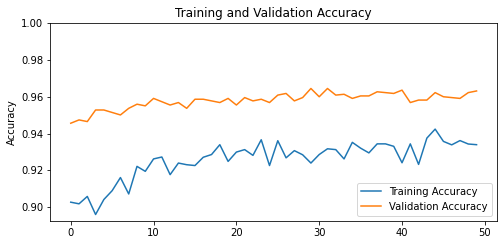

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

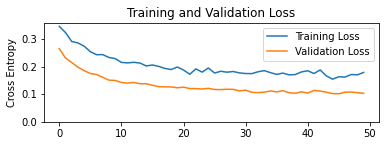

In [27]:
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [28]:
model.save('D:\\Personal\\Practice\\DL')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\Personal\Practice\DL\assets


#### Function to test custom image

In [67]:
def predict_image(image):
    scaled_image=image.astype('float32')
    scaled_image /= 255 
    #Resizing the image
    resized_image = cv2.resize(scaled_image, (160,160))
    #Normalization for each pixel
    print('The prediction-ready image:')
    plt.show(plt.imshow(resized_image, cmap='gray'))
    #predicting the digit
    prediction = model.predict(resized_image.reshape(1,resized_image.shape[0],resized_image.shape[1],3))
    if prediction[0][0]>0.5:
        print("Its a Dog")
    else:
        print("Its a cat")

In [70]:
image = cv2.imread('D:\Personal\Practice\DL\image_dog.jpg')

The prediction-ready image:


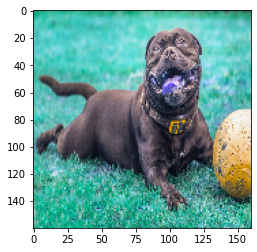

Its a Dog


In [71]:
#Calling the predict_image function
predict_image(image)